In [141]:
#Skip this cell if running for the first time
#if not, directly go to the last cell to predict on random images by replacing "output = face_mask_detector_cnn(inputs)"
#with "output = modelTrained(inputs)"
import os
import torch
if os.path.exists('phase2.pkl'):
    loaded_model = FaceMaskDetectorCNN()
    loaded_model.load_state_dict(torch.load('phase2.pkl'))
else:
    print("Model was not detected at specified location")

In [98]:
from tqdm import tqdm
from pathlib import Path
import pandas as pd

datasetPath = Path('dataset')
noMaskPath = datasetPath/'no'
clothMaskPath = datasetPath/'cloth'
FFP2MaskPath = datasetPath/'FFP2'
surgicalMaskPath = datasetPath/'surgical'
maskDF = pd.DataFrame()


for imgPath in tqdm(list(noMaskPath.iterdir()), desc='no'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 0
    }, ignore_index=True)
    
for imgPath in tqdm(list(clothMaskPath.iterdir()), desc='cloth'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 1
    }, ignore_index=True)
    
for imgPath in tqdm(list(FFP2MaskPath.iterdir()), desc='FFP2'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 2
    }, ignore_index=True)
    
for imgPath in tqdm(list(surgicalMaskPath.iterdir()), desc='surgical'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 3
    }, ignore_index=True)


dfName = 'dataset/dataset.pickle'
print(f'Saving Dataframe to: {dfName}')
maskDF.to_pickle(dfName)

surgical: 100%|██████████| 1754/1754 [00:03<00:00, 467.05it/s]

Saving Dataframe to: dataset/dataset.pickle


In [12]:
device = torch.device("cpu")

In [99]:
from PIL import Image
import numpy as np
from torch import long, tensor
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

class MaskDetectionDataset(Dataset):
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        self.transformations = Compose([
            Resize((32, 32)),
            ToTensor(),
            Normalize((0.5667, 0.5198, 0.4955),(0.3082, 0.2988, 0.3053))
        ])
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('Slicing is supported')
        
        row = self.dataFrame.iloc[key]
        image = Image.open(row['image']).convert('RGB')
        return {
          'image': self.transformations(image),
          'mask': tensor([row['mask']], dtype=long),
          'path': row['image']
        }
    
    def __len__(self):
        return len(self.dataFrame.index)

In [100]:
import torch
import torch.nn.init as init
import torch.nn as nn
from torch import Tensor
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU,Sequential, functional)
                      
class FaceMaskDetectorCNN(nn.Module):
    def __init__(self):
        super(FaceMaskDetectorCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(8 * 8 * 64, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 4)
        )
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

face_mask_detector_cnn = FaceMaskDetectorCNN()
print(face_mask_detector_cnn)

FaceMaskDetectorCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.01, inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.01, inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): LeakyReLU(negative_slope=0.01, inplace=True)

In [101]:
from pathlib import Path
from typing import Dict, List, Union
import pandas as pd
import torch
import torch.nn.init as init
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from torch import Tensor
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU,Sequential)
from torch.optim import Adam
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader
import itertools
import matplotlib.pyplot as plt

def plot_cm(cm, classes, normalize=False, title='Visualization of the confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('Actual True label')
    plt.xlabel('Predicted label')

def prepare_data(mask_df_path) -> None:
        mask_df = pd.read_pickle(mask_df_path)
        print(mask_df['mask'].value_counts())
        skf = StratifiedKFold(n_splits=10, shuffle=True)
        train_folds = []
        validate_folds = []
        for train_index, validate_index in skf.split(mask_df, mask_df['mask']):
            train_folds.append(MaskDetectionDataset(mask_df.iloc[train_index]))
            validate_folds.append(MaskDetectionDataset(mask_df.iloc[validate_index]))
        return [
            train_folds, validate_folds,CrossEntropyLoss()
            ]

def train_dataloader(train_df) -> DataLoader:
    return DataLoader(train_df, batch_size=32, shuffle=True, num_workers=0)

def val_dataloader(validate_df) -> DataLoader:
    return DataLoader(validate_df, batch_size=32, num_workers=0)   

train_dfs, validate_dfs, cross_entropy_loss = prepare_data("dataset/dataset.pickle")

2.0    1755
3.0    1754
0.0    1751
1.0    1749
Name: mask, dtype: int64


In [102]:
epochs = 10
learning_rate = 0.001 
retrain = False

import warnings
warnings.filterwarnings('ignore')

def train_model(train_fold):
    acc_list = []
    loss_list = []
    optimizer = Adam(face_mask_detector_cnn.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        total=0
        correct=0
        loss_train = 0.0
        for i, data in enumerate(train_dataloader(train_fold), 0):
            inputs, labels = data['image'], data['mask']
            labels = labels.flatten()
            outputs = face_mask_detector_cnn(inputs)
            loss = cross_entropy_loss(outputs, labels)
            loss_list.append(loss.item())
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            #training accuracy
            total += labels.size(0)
            _, predicted = torch.max(outputs.data, 1) 
            correct += (predicted == labels).sum().item() 
            loss_train += loss
        print('Training Loss after epoch {} : {} Accuracy: {:.2f}%'.format(epoch, loss_train,(correct / total) * 100))

In [103]:
from numpy import vstack
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def evaluate_model(validate_fold):
    predictions, actuals = torch.tensor([]), torch.tensor([])
    for i, data in enumerate(val_dataloader(validate_fold)):
        inputs, targets = data['image'], data['mask']
        targets = targets.flatten()
        output = face_mask_detector_cnn(inputs)
        output = torch.argmax(output,axis=1)
        predictions = torch.cat((predictions, output.flatten()), dim=0)
        actuals = torch.cat((actuals, targets), dim=0)

    return (confusion_matrix(actuals.numpy(), predictions.numpy()),accuracy_score(actuals, predictions),*precision_recall_fscore_support(actuals.numpy(), predictions.numpy(),average='macro'))

Running Fold : 1
Training Loss after epoch 0 : 202.57131958007812 Accuracy: 52.28%
Training Loss after epoch 1 : 83.13655090332031 Accuracy: 84.51%
Training Loss after epoch 2 : 52.48237609863281 Accuracy: 90.54%
Training Loss after epoch 3 : 39.98670959472656 Accuracy: 92.60%
Training Loss after epoch 4 : 31.134403228759766 Accuracy: 94.48%
Training Loss after epoch 5 : 29.355031967163086 Accuracy: 94.82%
Training Loss after epoch 6 : 20.271404266357422 Accuracy: 96.42%
Training Loss after epoch 7 : 21.04096794128418 Accuracy: 96.10%
Training Loss after epoch 8 : 17.321399688720703 Accuracy: 96.88%
Training Loss after epoch 9 : 14.126876831054688 Accuracy: 97.34%
Running Fold : 2
Training Loss after epoch 0 : 186.40927124023438 Accuracy: 56.80%
Training Loss after epoch 1 : 92.62956237792969 Accuracy: 81.44%
Training Loss after epoch 2 : 66.4485855102539 Accuracy: 87.94%
Training Loss after epoch 3 : 47.41682815551758 Accuracy: 91.09%
Training Loss after epoch 4 : 37.344879150390625 A

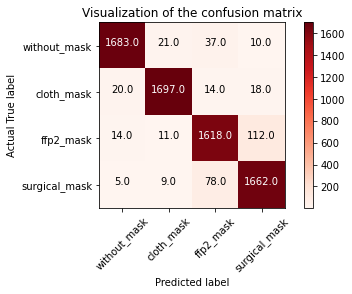

In [104]:
fold_results = []
fold_confusion_matrix = np.zeros((4,4))
classes = ['without_mask', 'cloth_mask', 'ffp2_mask', 'surgical_mask']

for fold_index in range(len(train_dfs)):
    print("Running Fold : "+ str(fold_index+1))
    train_model(train_dfs[fold_index])
    fold_result = evaluate_model(validate_dfs[fold_index])
    #conf_mat, acc, pre, recall, f-score
    fold_results.append(fold_result[1:-1])
    fold_confusion_matrix = np.add(fold_confusion_matrix,fold_result[0])
    if fold_index != len(train_dfs)-1:
        face_mask_detector_cnn = FaceMaskDetectorCNN()
    
metrics_df = pd.DataFrame(fold_results, columns=['accuracy', 'precision', 'recall', 'f-score'])
print()
print("Metrics")
print(metrics_df.mean())
print()
print("Across 10-folds")
plot_cm(fold_confusion_matrix, classes)

In [105]:
torch.save(face_mask_detector_cnn.state_dict(), 'phase2.pkl')

surgical: 100%|██████████| 102/102 [00:00<00:00, 271.84it/s]


testDataset\random\5f8f05ab9e9fe4001900a587.jfif
Predicted: cloth_mask


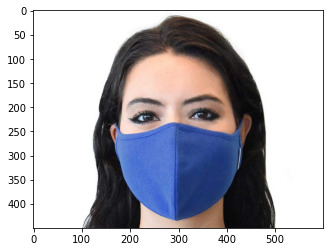

In [173]:
#Sample prediction
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

class_mapping = {
    0: "without_mask",
    1: "cloth_mask",
    2: "ffp2_mask",
    3: "surgical_mask"
}

def prepare_predict_df():
    testDatasetPath = Path('testDataset')
    testRandomMaskPath = testDatasetPath/'random'
    testDF = pd.DataFrame()

    for imgPath in tqdm(list(testRandomMaskPath.iterdir()), desc='no'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 0
        }, ignore_index=True)

    for imgPath in tqdm(list(testRandomMaskPath.iterdir()), desc='cloth'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 1
        }, ignore_index=True)

    for imgPath in tqdm(list(testRandomMaskPath.iterdir()), desc='ffp2'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 2
        }, ignore_index=True)
        
    for imgPath in tqdm(list(testRandomMaskPath.iterdir()), desc='surgical'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 3
        }, ignore_index=True)

    return MaskDetectionDataset(testDF)

def predict():
    test_df = prepare_predict_df()
    rand_sampler = torch.utils.data.RandomSampler(test_df, num_samples=32, replacement=True)
    data = iter(DataLoader(test_df, batch_size=32, num_workers=0, sampler=rand_sampler)).next()
    inputs,targets = data['image'], data['mask']
    output = face_mask_detector_cnn(inputs)
    output = torch.argmax(output,axis=1)
    rand_ind = random.choice(list(range(0,32)))
    print(data['path'][rand_ind])
    img = Image.open(data['path'][rand_ind])
    plt.imshow(np.asarray(img))
    print("Predicted:",class_mapping[output[rand_ind].tolist()])

predict()

In [107]:
print(fold_results)

[(0.948644793152639, 0.9490389254172438, 0.9487416032243619, 0.9485717180105367), (0.9429386590584878, 0.9452698655435144, 0.9429626623376623, 0.9434275721616598), (0.9529243937232525, 0.9551861839388935, 0.9528977272727274, 0.9533918809545665), (0.9372325249643366, 0.938721744989241, 0.937288961038961, 0.9375725563338325), (0.9372325249643366, 0.9403024900816502, 0.9373457792207792, 0.9374188324516867), (0.9657631954350927, 0.9659061018782547, 0.9657629870129869, 0.9657437916605625), (0.9514978601997147, 0.9533129102774502, 0.9515827922077922, 0.9514628605266024), (0.9600570613409415, 0.9610200024041062, 0.9600243506493507, 0.9598907655926632), (0.9443651925820257, 0.944632901066797, 0.9443668831168832, 0.9443608157017872), (0.9614285714285714, 0.9627664591586493, 0.9614285714285714, 0.9617995153104414)]


In [108]:
for x in range(len(fold_results)):
    print ('Fold {}',x,fold_results[x])

Fold {} 0 (0.948644793152639, 0.9490389254172438, 0.9487416032243619, 0.9485717180105367)
Fold {} 1 (0.9429386590584878, 0.9452698655435144, 0.9429626623376623, 0.9434275721616598)
Fold {} 2 (0.9529243937232525, 0.9551861839388935, 0.9528977272727274, 0.9533918809545665)
Fold {} 3 (0.9372325249643366, 0.938721744989241, 0.937288961038961, 0.9375725563338325)
Fold {} 4 (0.9372325249643366, 0.9403024900816502, 0.9373457792207792, 0.9374188324516867)
Fold {} 5 (0.9657631954350927, 0.9659061018782547, 0.9657629870129869, 0.9657437916605625)
Fold {} 6 (0.9514978601997147, 0.9533129102774502, 0.9515827922077922, 0.9514628605266024)
Fold {} 7 (0.9600570613409415, 0.9610200024041062, 0.9600243506493507, 0.9598907655926632)
Fold {} 8 (0.9443651925820257, 0.944632901066797, 0.9443668831168832, 0.9443608157017872)
Fold {} 9 (0.9614285714285714, 0.9627664591586493, 0.9614285714285714, 0.9617995153104414)


surgical: 100%|██████████| 539/539 [00:01<00:00, 509.85it/s]


Confusion matrix without normalization
[[229   2   0   0]
 [  3 235  10   3]
 [  0   3 238   3]
 [  0   0   0 274]]
Fold results for males:  (0.976, 0.9761211200275439, 0.9757517018718116, 0.9757700890960194)


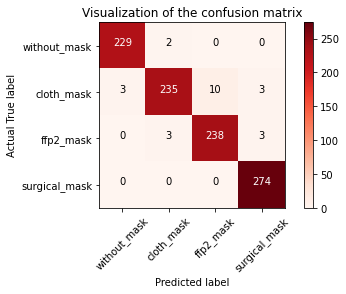

In [153]:
#MALE
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

class_mapping = {
    0: "without_mask",
    1: "cloth_mask",
    2: "ffp2_mask",
    3: "surgical_mask"
}

def prepare_predict_dfTest():
    
    testDatasetPath = Path('GenderWise')
    
    testMaleMaskPath = testDatasetPath/'male'
    testMaleMaskNoPath = testMaleMaskPath/'no'
    testMaleMaskClothPath = testMaleMaskPath/'cloth'
    testMaleMaskFFP2Path = testMaleMaskPath/'ffp2'
    testMaleMaskSurgicalPath = testMaleMaskPath/'surgical'
    
    testDF = pd.DataFrame()
    
    for imgPath in tqdm(list(testMaleMaskNoPath.iterdir()), desc='no'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 0
        }, ignore_index=True)

    for imgPath in tqdm(list(testMaleMaskClothPath.iterdir()), desc='cloth'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 1
        }, ignore_index=True)

    for imgPath in tqdm(list(testMaleMaskFFP2Path.iterdir()), desc='ffp2'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 2
        }, ignore_index=True)
        
    for imgPath in tqdm(list(testMaleMaskSurgicalPath.iterdir()), desc='surgical'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 3
        }, ignore_index=True)
            
    return MaskDetectionDataset(testDF)

def predict():
    predictions, actuals = torch.tensor([]), torch.tensor([])
    test_dfTest = prepare_predict_dfTest()
    rand_sampler = torch.utils.data.RandomSampler(test_dfTest, num_samples=1000, replacement=True)
    data = iter(DataLoader(test_dfTest, batch_size=1000, num_workers=0, sampler=rand_sampler)).next()
    inputs,targets = data['image'], data['mask']
    targets = targets.flatten()


    output = face_mask_detector_cnn(inputs)
    output = torch.argmax(output,axis=1)
    predictions = torch.cat((predictions, output.flatten()), dim=0)
    actuals = torch.cat((actuals, targets), dim=0)
    
    return (confusion_matrix(actuals.numpy(), predictions.numpy()),accuracy_score(actuals, predictions),*precision_recall_fscore_support(actuals.numpy(), predictions.numpy(),average='macro'))

fold_result_test = predict()
fold_confusion_matrix_test = fold_result_test[0]
fold_result_test_metrics = fold_result_test[1:-1]
plot_cm(fold_confusion_matrix_test, classes)

print("Fold results for males: ",fold_result_test_metrics)

surgical: 100%|██████████| 675/675 [00:01<00:00, 497.65it/s]


Confusion matrix without normalization
[[246   1   1   0]
 [  0 249   0   0]
 [  0   0 251  10]
 [  0   0   0 242]]
Fold results for females:  (0.988, 0.9880873015873016, 0.9884053269064392, 0.9880654997203884)


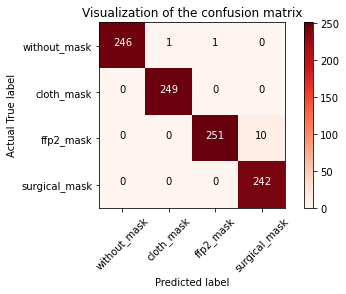

In [152]:
#FEMALE
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

class_mapping = {
    0: "without_mask",
    1: "cloth_mask",
    2: "ffp2_mask",
    3: "surgical_mask"
}

def prepare_predict_dfTest():
        
    testDatasetPath = Path('GenderWise')
    
    testFemaleMaskPath = testDatasetPath/'female'
    testFemaleMaskNoPath = testFemaleMaskPath/'no'
    testFemaleMaskClothPath = testFemaleMaskPath/'cloth'
    testFemaleMaskFFP2Path = testFemaleMaskPath/'ffp2'
    testFemaleMaskSurgicalPath = testFemaleMaskPath/'surgical'
    
    testDF = pd.DataFrame()
    
    for imgPath in tqdm(list(testFemaleMaskNoPath.iterdir()), desc='no'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 0
        }, ignore_index=True)

    for imgPath in tqdm(list(testFemaleMaskClothPath.iterdir()), desc='cloth'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 1
        }, ignore_index=True)

    for imgPath in tqdm(list(testFemaleMaskFFP2Path.iterdir()), desc='ffp2'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 2
        }, ignore_index=True)
        
    for imgPath in tqdm(list(testFemaleMaskSurgicalPath.iterdir()), desc='surgical'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 3
        }, ignore_index=True)
            
    return MaskDetectionDataset(testDF)

def predict():
    predictions, actuals = torch.tensor([]), torch.tensor([])
    test_dfTest = prepare_predict_dfTest()
    rand_sampler = torch.utils.data.RandomSampler(test_dfTest, num_samples=1000, replacement=True)
    data = iter(DataLoader(test_dfTest, batch_size=1000, num_workers=0, sampler=rand_sampler)).next()
    inputs,targets = data['image'], data['mask']
    targets = targets.flatten()


    output = face_mask_detector_cnn(inputs)
    output = torch.argmax(output,axis=1)
    predictions = torch.cat((predictions, output.flatten()), dim=0)
    actuals = torch.cat((actuals, targets), dim=0)
    
    return (confusion_matrix(actuals.numpy(), predictions.numpy()),accuracy_score(actuals, predictions),*precision_recall_fscore_support(actuals.numpy(), predictions.numpy(),average='macro'))

fold_result_test = predict()
fold_confusion_matrix_test = fold_result_test[0]
fold_result_test_metrics = fold_result_test[1:-1]
plot_cm(fold_confusion_matrix_test, classes)

print("Fold results for females: ",fold_result_test_metrics)

surgical: 100%|██████████| 349/349 [00:00<00:00, 497.94it/s]


Confusion matrix without normalization
[[245   4   1   0]
 [  1 228   0   0]
 [  0   0  51 188]
 [  0   0   0 282]]
Fold results for young aged people:  (0.806, 0.8898657027021198, 0.7972555772779595, 0.7693931756847905)


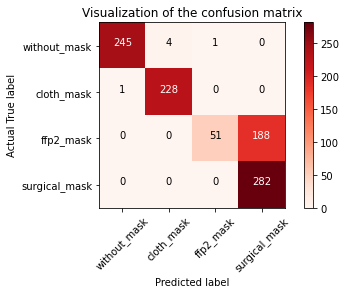

In [157]:
#YOUNG
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

class_mapping = {
    0: "without_mask",
    1: "cloth_mask",
    2: "ffp2_mask",
    3: "surgical_mask"
}

def prepare_predict_dfTest():
        
    testDatasetPath = Path('AgeWise')
    
    testYoungMaskPath = testDatasetPath/'young'
    testYoungMaskNoPath = testYoungMaskPath/'no'
    testYoungMaskClothPath = testYoungMaskPath/'cloth'
    testYoungMaskFFP2Path = testYoungMaskPath/'ffp2'
    testYoungMaskSurgicalPath = testYoungMaskPath/'surgical'
    
    testDF = pd.DataFrame()
      
    for imgPath in tqdm(list(testYoungMaskNoPath.iterdir()), desc='no'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 0
        }, ignore_index=True)

    for imgPath in tqdm(list(testYoungMaskClothPath.iterdir()), desc='cloth'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 1
        }, ignore_index=True)

    for imgPath in tqdm(list(testYoungMaskFFP2Path.iterdir()), desc='ffp2'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 2
        }, ignore_index=True)
        
    for imgPath in tqdm(list(testYoungMaskSurgicalPath.iterdir()), desc='surgical'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 3
        }, ignore_index=True)
            
    return MaskDetectionDataset(testDF)

def predict():
    predictions, actuals = torch.tensor([]), torch.tensor([])
    test_dfTest = prepare_predict_dfTest()
    rand_sampler = torch.utils.data.RandomSampler(test_dfTest, num_samples=1000, replacement=True)
    data = iter(DataLoader(test_dfTest, batch_size=1000, num_workers=0, sampler=rand_sampler)).next()
    inputs,targets = data['image'], data['mask']
    targets = targets.flatten()


    output = face_mask_detector_cnn(inputs)
    output = torch.argmax(output,axis=1)
    predictions = torch.cat((predictions, output.flatten()), dim=0)
    actuals = torch.cat((actuals, targets), dim=0)
    
    return (confusion_matrix(actuals.numpy(), predictions.numpy()),accuracy_score(actuals, predictions),*precision_recall_fscore_support(actuals.numpy(), predictions.numpy(),average='macro'))

fold_result_test = predict()
fold_confusion_matrix_test = fold_result_test[0]
fold_result_test_metrics = fold_result_test[1:-1]
plot_cm(fold_confusion_matrix_test, classes)

print("Fold results for young aged people: ",fold_result_test_metrics)

surgical: 100%|██████████| 353/353 [00:00<00:00, 493.13it/s]


Confusion matrix without normalization
[[241   1   3   0]
 [  1 230   0   0]
 [  0   0  46 207]
 [  0   0   0 271]]
Fold results for middle aged people:  (0.788, 0.8743149702911699, 0.7902906617192331, 0.753417831371723)


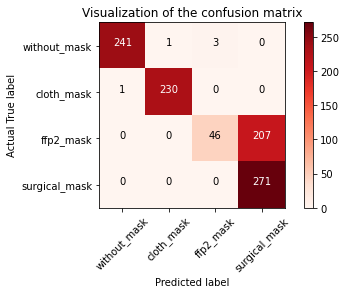

In [163]:
#MIDDLE
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

class_mapping = {
    0: "without_mask",
    1: "cloth_mask",
    2: "ffp2_mask",
    3: "surgical_mask"
}

def prepare_predict_dfTest():
    
    testDatasetPath = Path('AgeWise')
    
    testMidleMaskPath = testDatasetPath/'middle'
    testMiddleMaskNoPath = testMidleMaskPath/'no'
    testMiddleMaskClothPath = testMidleMaskPath/'cloth'
    testMiddleMaskFFP2Path = testMidleMaskPath/'ffp2'
    testMiddleMaskSurgicalPath = testMidleMaskPath/'surgical'
    
    testDF = pd.DataFrame()
    
    for imgPath in tqdm(list(testMiddleMaskNoPath.iterdir()), desc='no'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 0
        }, ignore_index=True)

    for imgPath in tqdm(list(testMiddleMaskClothPath.iterdir()), desc='cloth'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 1
        }, ignore_index=True)

    for imgPath in tqdm(list(testMiddleMaskFFP2Path.iterdir()), desc='ffp2'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 2
        }, ignore_index=True)
        
    for imgPath in tqdm(list(testMiddleMaskSurgicalPath.iterdir()), desc='surgical'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 3
        }, ignore_index=True)
            
    return MaskDetectionDataset(testDF)

def predict():
    predictions, actuals = torch.tensor([]), torch.tensor([])
    test_dfTest = prepare_predict_dfTest()
    rand_sampler = torch.utils.data.RandomSampler(test_dfTest, num_samples=1000, replacement=True)
    data = iter(DataLoader(test_dfTest, batch_size=1000, num_workers=0, sampler=rand_sampler)).next()
    inputs,targets = data['image'], data['mask']
    targets = targets.flatten()


    output = face_mask_detector_cnn(inputs)
    output = torch.argmax(output,axis=1)
    predictions = torch.cat((predictions, output.flatten()), dim=0)
    actuals = torch.cat((actuals, targets), dim=0)
    
    return (confusion_matrix(actuals.numpy(), predictions.numpy()),accuracy_score(actuals, predictions),*precision_recall_fscore_support(actuals.numpy(), predictions.numpy(),average='macro'))

fold_result_test = predict()
fold_confusion_matrix_test = fold_result_test[0]
fold_result_test_metrics = fold_result_test[1:-1]
plot_cm(fold_confusion_matrix_test, classes)

print("Fold results for middle aged people: ",fold_result_test_metrics)

surgical: 100%|██████████| 384/384 [00:00<00:00, 402.34it/s]


Confusion matrix without normalization
[[245   0   3   0]
 [  0 224  34   0]
 [  1   0  48 182]
 [  0   1   1 261]]
Fold results for old aged people:  (0.778, 0.7846987088354793, 0.7640769812811458, 0.7404137382874103)


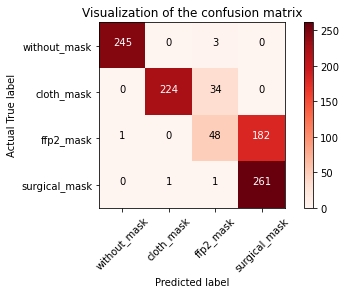

In [166]:
#OLD
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

class_mapping = {
    0: "without_mask",
    1: "cloth_mask",
    2: "ffp2_mask",
    3: "surgical_mask"
}

def prepare_predict_dfTest():
    
    testDatasetPath = Path('AgeWise')
    
    testOddMaskPath = testDatasetPath/'old'
    testOldMaskNoPath = testOddMaskPath/'no'
    testOldMaskClothPath = testOddMaskPath/'cloth'
    testOldMaskFFP2Path = testOddMaskPath/'ffp2'
    testOldMaskSurgicalPath = testOddMaskPath/'surgical'
    
    testDF = pd.DataFrame()
    
    for imgPath in tqdm(list(testOldMaskNoPath.iterdir()), desc='no'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 0
        }, ignore_index=True)

    for imgPath in tqdm(list(testOldMaskClothPath.iterdir()), desc='cloth'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 1
        }, ignore_index=True)

    for imgPath in tqdm(list(testOldMaskFFP2Path.iterdir()), desc='ffp2'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 2
        }, ignore_index=True)
        
    for imgPath in tqdm(list(testOldMaskSurgicalPath.iterdir()), desc='surgical'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 3
        }, ignore_index=True)
            
    return MaskDetectionDataset(testDF)

def predict():
    predictions, actuals = torch.tensor([]), torch.tensor([])
    test_dfTest = prepare_predict_dfTest()
    rand_sampler = torch.utils.data.RandomSampler(test_dfTest, num_samples=1000, replacement=True)
    data = iter(DataLoader(test_dfTest, batch_size=1000, num_workers=0, sampler=rand_sampler)).next()
    inputs,targets = data['image'], data['mask']
    targets = targets.flatten()


    output = face_mask_detector_cnn(inputs)
    output = torch.argmax(output,axis=1)
    predictions = torch.cat((predictions, output.flatten()), dim=0)
    actuals = torch.cat((actuals, targets), dim=0)
    
    return (confusion_matrix(actuals.numpy(), predictions.numpy()),accuracy_score(actuals, predictions),*precision_recall_fscore_support(actuals.numpy(), predictions.numpy(),average='macro'))

fold_result_test = predict()
fold_confusion_matrix_test = fold_result_test[0]
fold_result_test_metrics = fold_result_test[1:-1]
plot_cm(fold_confusion_matrix_test, classes)

print("Fold results for old aged people: ",fold_result_test_metrics)